In [5]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../funcs')
from spectral1d import QuantumReflection

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT

from qiskit.circuit.library import PiecewisePolynomialPauliRotationsGate
from numpy.polynomial import polynomial as poly


In [6]:
def forcing(x,l):
    """Forcing function"""
    forcing_function = 100. * np.cos(2*x*np.pi/l) * np.cos(5.*x*np.pi/l)
    return forcing_function

def solutionAnalytic(x, l):
    """Analytic solution"""
    solution = (100.*(-58+116*x + 49*np.cos(3*np.pi*x) + 9*np.cos(7*np.pi*x))/(882 * np.pi**2)) + 0.5*(1 + x)
    return solution

# boundary-verifying function and its second derivative
def g(x,l):
    return x**3 - 0.5*((x-1)**3)

def d2g(x,l):
    return 3*x + 3

@np.vectorize
def freqs_inv(k):
    """solution operator in frequency domain"""
    return 1/(np.pi**2*k**2)

def break_points_pwc(n_pts, eps=1e-6): 
    """Break points for piecewise Chebychev interpolation"""
    pt = n_pts // 2
    break_pts_1 = []

    # break points for the first half of the spectrum
    while pt > 1:
        pt = pt // 2
        break_pts_1.append(pt-eps)

    # break points for the second half of the spectrum
    break_pts_1 = break_pts_1[::-1]
    break_pts_1.append((n_pts/2)-eps)
    break_pts_1.append(n_pts-eps)

    # combine the two lists and return
    return (break_pts_1)


In [7]:
# function to approximate
@np.vectorize(otypes=[float])
def twoTheta(k):
    # factor of 2 is needed because Ry(2θ) applies the rotation by θ
    if k == 0:
        return 0
    return 2*np.arccos(1/(np.pi**2 * k**2))

def polynomials(func, degree, breakpoints):
    num_intervals = len(breakpoints)

    polynomials = []
    
    for i in range(num_intervals-1):
        x = np.linspace(breakpoints[i], breakpoints[i + 1], num=degree+1)
        
        # Vandermonde matrix
        van_mat = poly.polyvander(x, degree)
         
        # condition Vandermonde matrix to avoid ill-conditioning
        scale = np.abs(van_mat).sum(axis=0)
        van_mat /= scale

        poly_coeffs, resids, rank, s = np.linalg.lstsq(van_mat, func(x), rcond=None)
        poly_coeffs = (poly_coeffs.T / scale).T  

        polynomials.append(poly_coeffs.tolist())

    return polynomials

/var/folders/tn/bpv7203512s5w_qmpd5848z80000gn/T/ipykernel_11233/2011294243.py:43: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(num_qubits=n_state_qubits_ext,inverse=False).to_gate()


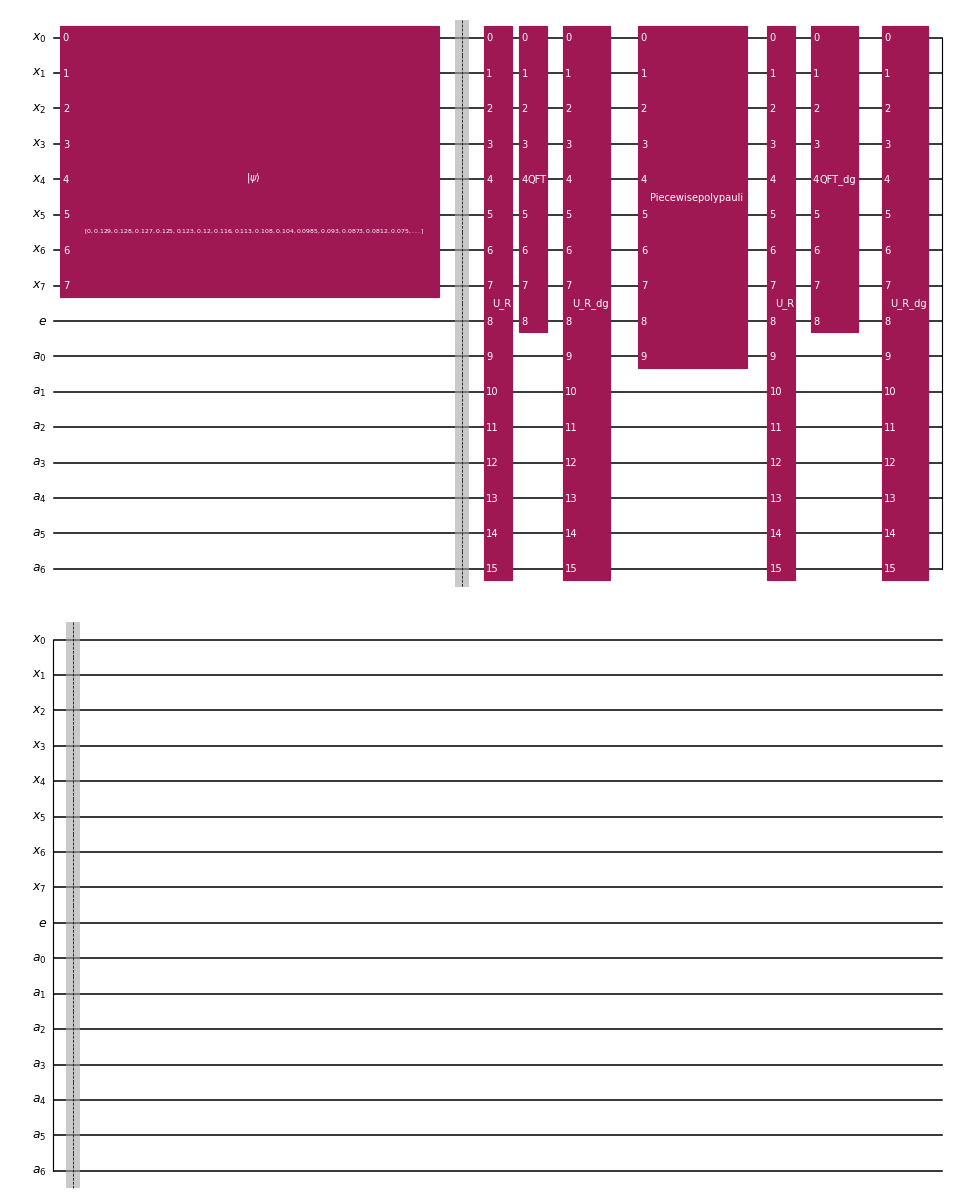

In [8]:
# number of qubits for discretisation
n_state_qubits = 8                          # excluding the extended domain
n_state_qubits_ext = n_state_qubits + 1     # including the extended domain

n_pts = 2**n_state_qubits
n_pts_ext = 2**n_state_qubits_ext

# discretize the domain interval [0,1]
l     = 1.          # domain
l_ext = 2*l         # extended domain
h     = l/n_pts 
x     = np.linspace(0, l-h, n_pts)

# forcing vector
f_i    = forcing(x, 1)
f_i   += d2g(x, 1)
f_i[0] = 0.   # make sure zero at the first element
norm_f = np.linalg.norm(f_i)
f      = f_i/norm_f

method_u_f = "ripple-carry"  
if method_u_f == "mcx":
    n_ancillas = 1
else:
    n_ancillas = n_state_qubits -1

# initialise quantum circuit with n_state_qubits and n_state_qubits+1 ancillas
qcs = QuantumRegister(n_state_qubits, 'x')  # spatial discretisation qubits
qce = QuantumRegister(1, 'e')               # extension qubit
qca = QuantumRegister(n_ancillas, 'a')  # ancillary qubits
qc  = QuantumCircuit(qcs, qce, qca)

# initialise state using in-built Qiskit state prep function
qc.initialize(f, list(range(n_state_qubits)))
qc.barrier()

# add reflection unitary U_R to the circuit
qr = QuantumReflection(n_state_qubits, 1, method_u_f=method_u_f)
qr_gate = qr.build()
qc.append(qr_gate, list(range(qr.n_dst)))

# apply QFT
qft = QFT(num_qubits=n_state_qubits_ext,inverse=False).to_gate()
qc.append(qft, list(range(n_state_qubits_ext)))

# add inverse of U_R to the circuit
qref_inv = qr.inverse()
qr_inv_gate = qref_inv.to_gate(label="U_R_dg")
qc.append(qr_inv_gate, list(range(qr.n_dst)))  

# piecewise polynomial approximation
degree = 4       # degree of the polynomial

# manually set breakpoints
breakpoints = [1, degree+1, 2*degree+1, 3*degree+1, 5*degree+1, 8*degree+1,  n_pts] 

poly_coeffs = polynomials(twoTheta, degree, breakpoints)

pw_approximation = PiecewisePolynomialPauliRotationsGate(n_state_qubits, breakpoints, poly_coeffs)
qc.append(pw_approximation, list(range(n_state_qubits+2)))

# apply inverse spectral transformation
qc.append(qr_gate, list(range(qr.n_dst)))
qc.append(qft.inverse(), list(range(n_state_qubits_ext))) 
qc.append(qr_inv_gate, list(range(qr.n_dst)))  

qc.barrier()

# visualize circuit
qc.draw("mpl", scale=0.55)

In [9]:
state = Statevector.from_label('0' * qc.num_qubits)
state = state.evolve(qc)

# extract the result from the state 
out = np.array(state.data[0:n_pts_ext])
result = np.real(norm_f*out)

# L2 norm of the error
error = np.linalg.norm((result[0:n_pts] + g(x[0:n_pts],l)) - solutionAnalytic(x[0:n_pts], l))
print('L2 norm of the error: ', error / n_pts)

L2 norm of the error:  6.573261716393041e-06


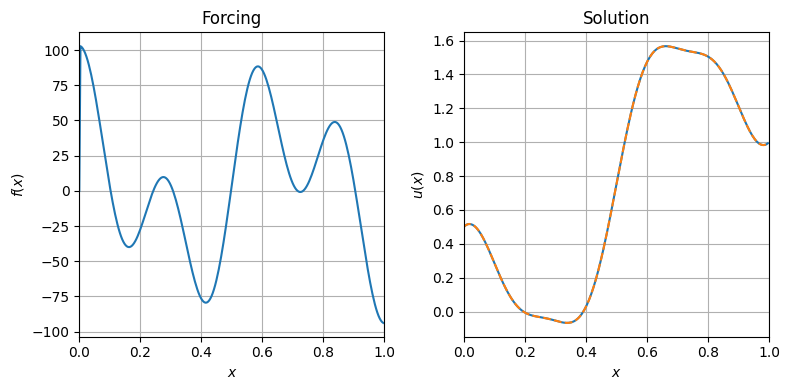

In [10]:
# plot the forcing and solution
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1) 
plt.title('Forcing') 
plt.plot(x, f_i)
plt.xlim(0, l)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid()

plt.subplot(1, 2, 2)  
plt.title('Solution')
plt.plot(x, result[0:n_pts]+g(x,l))
plt.plot(x, solutionAnalytic(x,l), '--')
plt.xlim(0, l)
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.grid()

plt.tight_layout()
plt.show()

In [11]:
from qiskit.compiler import transpile
transp = transpile(qc, basis_gates=['u3','cx'], optimization_level=3)
transp.count_ops()

OrderedDict([('u3', 207951), ('cx', 156978), ('reset', 8), ('barrier', 2)])